In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import misc
from scipy.stats import norm, lognorm

We model stock price as a stochastic variable with drift $\mu$ and vol $\sigma$ such that:
\begin{equation}
    S_1 = S_0(1 + \mu dt + \sigma \sqrt{t}dw)
\end{equation}

For small time-scales and volatility, we can use lognormal returns as an approximation.

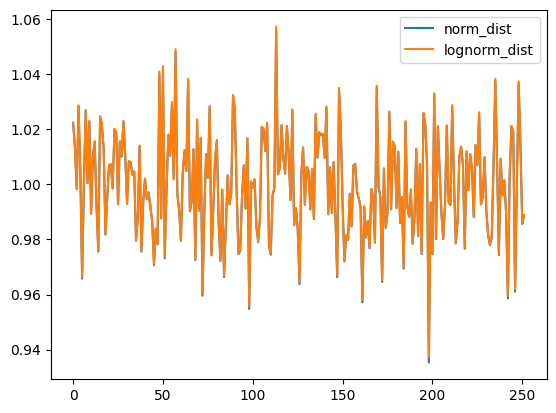

In [2]:
# Simulate daily returns for 1 year
drift = 0.02
vol = 0.3
step_size = 1/252

rn = np.random.rand(252)
norm1 = norm.ppf(rn, loc=drift * step_size, scale=vol * np.sqrt(step_size)) + 1
plt.plot(norm1, label='norm_dist')

lognorm1 = lognorm.ppf(rn, vol * np.sqrt(step_size), loc=0, scale=np.exp(drift * step_size))
plt.plot(lognorm1, label='lognorm_dist')
plt.legend()
plt.show()

Estimate the error of the lognormal approximation by simulating the returns after 1 year:

In [3]:
# normal distribution
f = 1 + drift + vol * np.random.normal(0, 1, size=10000000)
print(f'mean return after 1 year: {np.mean(f) - 1}')
print(f'drift: {drift}')

mean return after 1 year: 0.020012769360067573
drift: 0.02


In [4]:
# lognormal distribution
f = lognorm.ppf(np.random.rand(10000000), s=vol, loc=0, scale=np.exp(drift))
print(f'mean return after 1 year: {np.mean(f) - 1}')
print(f'drift + 0.5 * vol^2: {0.5 * vol ** 2 + drift}')

mean return after 1 year: 0.06728679992702258
drift + 0.5 * vol^2: 0.065


Difference between normal and lognormal distributions is $0.5\text{vol}^2$.

We note that the expectation of lognormal distribution with mean $\mu$ and standard deviation $\sigma$ is $e^{\mu + \frac{\sigma ^ 2}{2}}$.

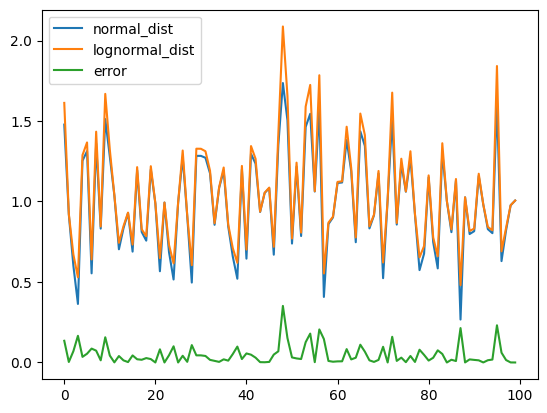

In [5]:
# simulate error for each calculation
n = []
lgn = []
for i in range(100):
    w = np.random.rand()
    n.append(1 + drift + vol * norm.ppf(w, loc=0, scale=1))
    lgn.append(lognorm.ppf(w, s=vol, loc=0, scale=np.exp(drift)))

n = np.array(n)
lgn = np.array(lgn)

plt.plot(n, label='normal_dist')
plt.plot(lgn, label='lognormal_dist')
plt.plot((lgn - n), label='error')
plt.legend()
plt.show()

Errors are random and small compared to correct returns

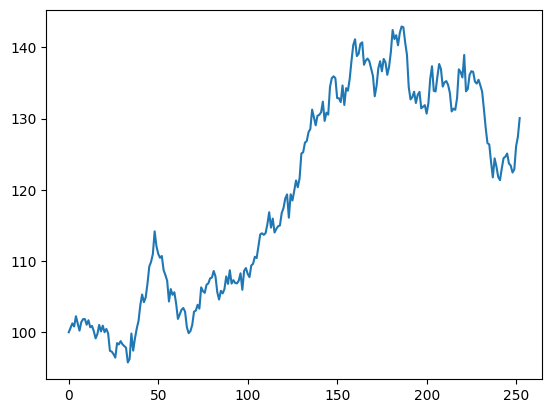

In [6]:
drift = 0.01
vol = 0.2
initial_stock_price = 100

def generate_stochastic_stock_price(drift, vol, initial_price, num_steps, step_size):
    '''
    drift, vol, step_size to be quoted as annualised values
    e.g. step_size = (1 / 252) for daily stock price
    '''
    w = np.random.normal(0, 1, size=num_steps)
    returns = 1 + drift * step_size + vol * np.sqrt(step_size) * w
    returns = np.insert(returns, 0, 1)
    prices = initial_price * np.cumprod(returns)
    return prices

plt.plot(generate_stochastic_stock_price(drift, vol, initial_stock_price, 252, 1 / 252))


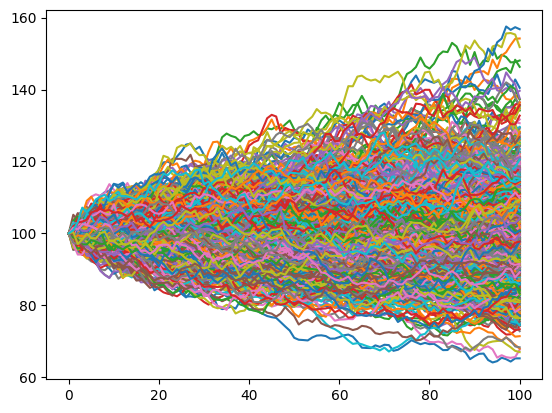

In [7]:
price_series_arr = np.array([generate_stochastic_stock_price(drift, vol, initial_stock_price, 100, 1/252) for f in range(1000)])
for f in price_series_arr:
    plt.plot(f)
plt.show()

Simulate an option contract

average payoff: 7.573666870989946


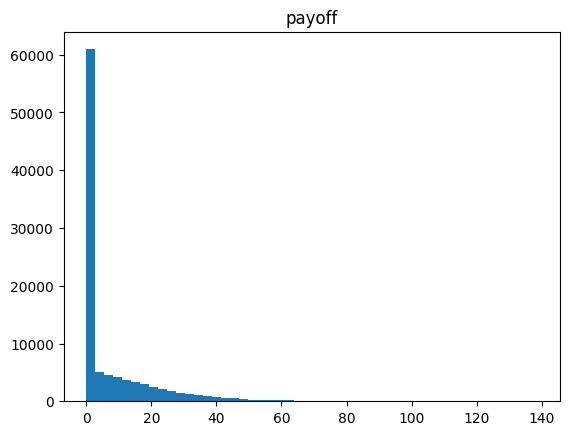

In [8]:
num_trials = 100000
# stock parameters
drift = 0
vol = 0.2
initial_stock_price = 100
step_size = 1/252

# call option parameters
strike = 101
dte = 252
payoffs = []

price_series_arr = np.array([generate_stochastic_stock_price(drift, vol, initial_stock_price, dte, step_size) for f in range(num_trials)])
for i in range(num_trials):
    final_price = price_series_arr[i][-1]
    payoffs.append(max(0, final_price - strike))
payoffs = np.array(payoffs)

print(f'average payoff: {np.mean(payoffs)}')

plt.hist(payoffs, bins=50)
plt.title('payoff')
plt.show()

The price of the option should be equal to the expected payoff. We can compare to the simulated price to the black scholes model.

In [9]:
from utils import bsm

print(f'BSM call price: {bsm.get_call_price(strike, dte, initial_stock_price, vol, div_yield=0, rf_rate=0)}')

BSM call price: 7.515267758969337


Suppose we buy a call option and hedge it every day by shorting stock:

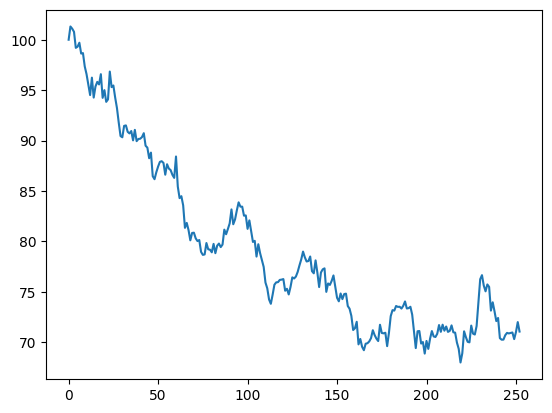

In [10]:
# generate price series
price_series = generate_stochastic_stock_price(drift, vol, initial_stock_price, dte, step_size)
plt.plot(price_series)
plt.show()

c:\Users\alexr\Quantitative_Finance_Modelling\utils\bsm.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(curr_price / strike) \


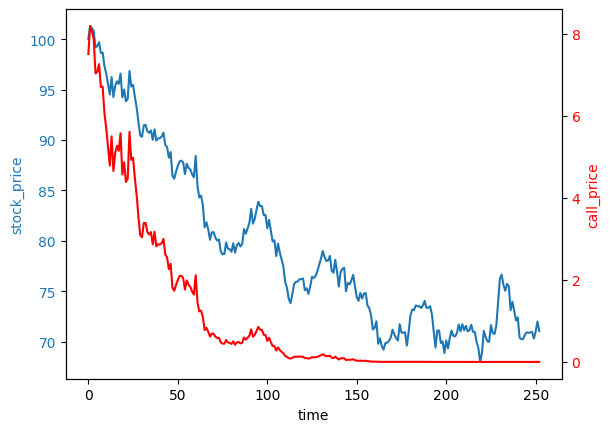

In [11]:
# simulate option price
dte_arr = np.arange(dte, -1, -1)
call_price_arr = np.array([bsm.get_call_price(strike, dte_arr[i], price_series[i], vol) for i in range(dte + 1)])

fig, ax1 = plt.subplots()
t = np.arange(0, dte + 1, 1)

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('stock_price', color=color)
ax1.plot(t, price_series, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2 = ax1.twinx()
ax2.set_ylabel('call_price', color=color)
ax2.plot(t, call_price_arr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

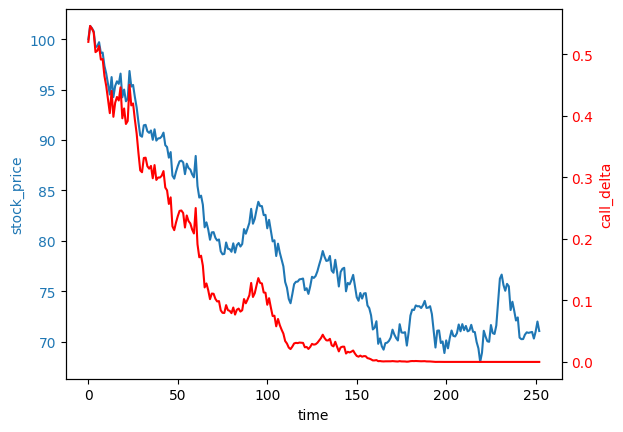

In [12]:
# simulate call delta
call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], vol) for i in range(dte + 1)])

t = np.arange(0, dte + 1, 1)
fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('stock_price', color=color)
ax1.plot(t, price_series, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2 = ax1.twinx()
ax2.set_ylabel('call_delta', color=color)
ax2.plot(t, call_delta_arr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

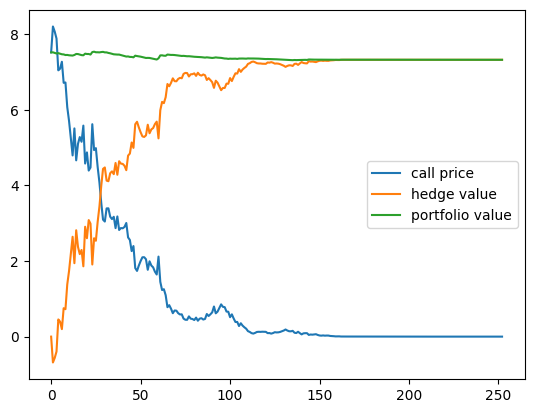

In [13]:
# hedge call by shorting shares equivalent to call delta

hedge_profit_arr = []
for i in range(dte):
    # open short hedge today and close the next day
    hgp = -call_delta_arr[i] * (price_series[i + 1] - price_series[i])
    hedge_profit_arr.append(hgp)
hedge_profit_arr = np.array(hedge_profit_arr)

# value of the hedge = cumulative sum of hedge profits
hedge_value_arr = np.cumsum(hedge_profit_arr)
hedge_value_arr = np.insert(hedge_value_arr, 0, 0)

# portfolio value = sum of call option value and hedge value
port_value_arr = call_price_arr + hedge_value_arr

plt.plot(call_price_arr, label='call price')
plt.plot(hedge_value_arr, label='hedge value')
plt.plot(port_value_arr, label='portfolio value')
plt.legend()
plt.show()


We note there is some change in the portfolio value, even though we hedged perfectly according the black scholes model. Since we have created a risk-free portfolio by hedging, we should make the risk-free rate (0 in this case). However, there is clearly some change in portfolio value

In [14]:
print(f'total P&L on portfolio: {port_value_arr[-1] - port_value_arr[0]}')

total P&L on portfolio: -0.19615430240820153


We can run this simulation multiple times and observe the total portfolio P&L.

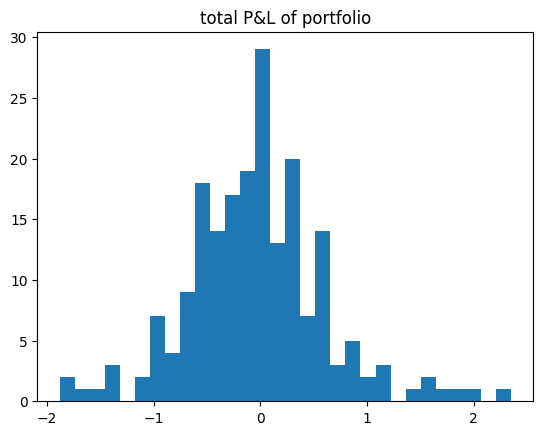

average P&L: -0.03487161067060201


In [31]:
# simulate multiple times:
def simulate_hedged_port_profit(num_trials=200):
    dte_arr = np.arange(dte, -1, -1)
    port_profit_arr = []
    for i in range(num_trials):
        # generate price series
        price_series = generate_stochastic_stock_price(drift, vol, initial_stock_price, dte, step_size)
        call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], vol) for i in range(dte + 1)])
        # compute hedge profit
        hedge_profit_arr = np.array([-call_delta_arr[i] * (price_series[i + 1] - price_series[i]) for i in range(dte)])
        # value of the hedge = cumulative sum of hedge profits
        hedge_profit = np.sum(hedge_profit_arr)
        port_profit = hedge_profit + max(0, price_series[-1] - strike) - bsm.get_call_price(strike, dte, initial_stock_price, vol)
        port_profit_arr.append(port_profit)
    return np.array(port_profit_arr)

port_profit_arr = simulate_hedged_port_profit()
plt.hist(port_profit_arr, bins=30)
plt.title('total P&L of portfolio')
plt.show()

print(f'average P&L: {np.mean(port_profit_arr)}')
    

The profit/error is small and seems to follow a normal distribution.

We suspect the discrepancy to be due to truncation error. Black-scholes assumes continuous hedging, but we are hedging once per day. If this hypothesis is correct, if we hedge less frequently, e.g. once per 2 days, we should get a bigger error. Since the error depends on the path of the stock price, which is random, the error should be random as well. Therefore, the error should be centered about 0 and have increasing standard deviation as the hedge period increases. 

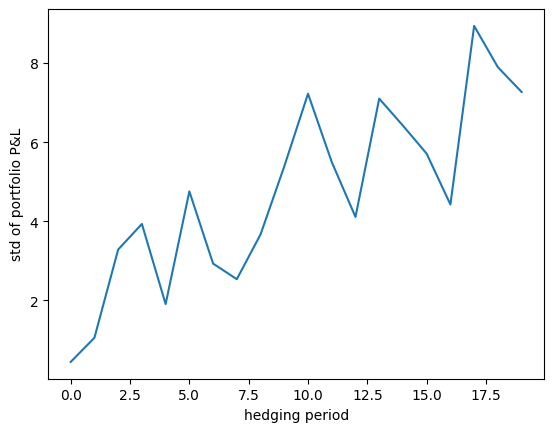

In [16]:
def simulate_hedged_port_profit(hedge_period=1, num_trials=1000):
    dte_arr = np.arange(dte, -1, -1)
    port_profit_arr = []
    for i in range(num_trials):
        # generate price series
        price_series = generate_stochastic_stock_price(drift, vol, initial_stock_price, dte, step_size)
        call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], vol) for i in range(dte + 1)])
        j = 0
        hedge_profit = 0
        while j + hedge_period <= dte:
            hgp = -call_delta_arr[j] * (price_series[j + hedge_period] - price_series[j])
            hedge_profit += hgp
            j += hedge_period
        port_profit = hedge_profit + max(0, price_series[-1] - strike) - bsm.get_call_price(strike, dte, initial_stock_price, vol)
        port_profit_arr.append(port_profit)
    return np.array(port_profit_arr)

port_profit_by_hedge_period = []
for i in range(1, 100, 5):
    port_profit_arr = simulate_hedged_port_profit(hedge_period=i)
    port_profit_by_hedge_period.append(np.std(port_profit_arr))
plt.plot(port_profit_by_hedge_period)
plt.ylabel('std of portfolio P&L')
plt.xlabel('hedging period')
plt.show()

Consider the case where we are making an implied vol trade with a call option. 

The market price of the call indicates an implied vol of $v_1 = 0.2$, but we predict the volatility of the stock price over the lifetime of the option to be $v_2 = 30$.

We believe that the option is underpriced compared to expectation of the final payoffs. Therefore, we should buy the call option and hold it till expiration.

average profit: 1.4252120673880522


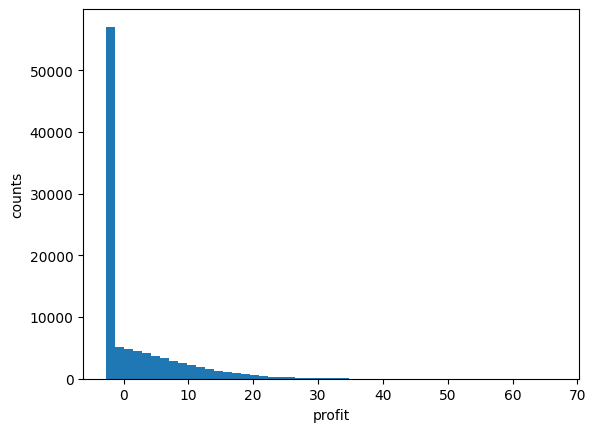

In [17]:
v1 = 0.2
v2 = 0.3
strike = 100
dte = 30
init_stock_price = 100
drift = 0
step_size = 1/252


init_call_price = bsm.get_call_price(strike, dte, init_stock_price, v1)

payoff_arr = []
for i in range(100000):
    # assume that our model is correct
    price_series = generate_stochastic_stock_price(drift, v2, init_stock_price, dte, step_size)
    payoff = max(price_series[-1] - strike, 0)
    payoff_arr.append(payoff)
payoff_arr = np.array(payoff_arr)

# profit is the payoff - initial price we paid for call option
profit_arr = payoff_arr - init_call_price

print(f'average profit: {np.mean(profit_arr)}')
plt.hist(profit_arr, bins=50)
plt.xlabel('profit')
plt.ylabel('counts')
plt.show()


The performance and risk-profile of this strategy is not ideal.

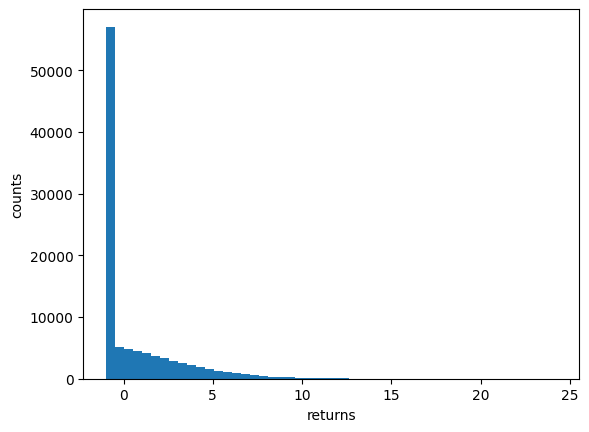

mean return: 0.5178038022503267
return std: 2.3483957803589175


In [18]:
returns_arr = np.array([profit_arr[i] / init_call_price for i in range(len(profit_arr))])
plt.hist(returns_arr, bins=50)
plt.xlabel('returns')
plt.ylabel('counts')
plt.show()

print(f'mean return: {np.mean(returns_arr)}')
print(f'return std: {np.std(returns_arr)}')

This strategy presents highly skewed and highly volatile returns.

We can get a better risk profile by delta hedging. We can purchase the call and short the stock according to the delta of the call each day.

 However, we need to choose between using the model volatility $v_2$ or the implied volatility $v_1$ for hedging.

We simulate 4 cases:
- actual 20 vol, hedged to 20 vol
- actual 30 vol, hedged to 20 vol
- actual 20 vol, hedged to 30 vol
- actual 30 vol, hedged to 30 vol

In [67]:
# implied 20 vol
init_call_price = bsm.get_call_price(strike, dte, init_stock_price, 0.2)
dte_arr = np.arange(dte, -1, -1)
strike = 100
dte = 30
init_stock_price = 100
drift = 0
step_size = 1/252
num_trials = 10000

# simulate 20 vol, hedge to 20 and 30 vol

payoff_arr = []
hedge20_profit_arr = []
hedge30_profit_arr = []
real_vol_arr = []
final_price_arr = []

for i in range(num_trials):
    # generate price series
    price_series = generate_stochastic_stock_price(drift, 0.2, init_stock_price, dte, step_size)
    # realised volatility
    real_vol = np.std(np.diff(price_series) / price_series[:-1])
    real_vol_arr.append(real_vol)
    # final price
    final_price_arr.append(price_series[-1])
    # generate call delta according to implied vol and model vol
    hedge20_call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], 0.2) for i in range(dte + 1)])
    hedge30_call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], 0.3) for i in range(dte + 1)])
    # hedge with stock
    hedge20_profit = np.sum([-hedge20_call_delta_arr[i] * (price_series[i + 1] - price_series[i]) for i in range(dte)])
    hedge30_profit = np.sum([-hedge30_call_delta_arr[i] * (price_series[i + 1] - price_series[i]) for i in range(dte)])
    hedge20_profit_arr.append(hedge20_profit)
    hedge30_profit_arr.append(hedge30_profit)
    # calculate payoff
    payoff = max(price_series[-1] - strike, 0)
    payoff_arr.append(payoff)

# convert to np array
payoff_arr = np.array(payoff_arr)
hedge20_profit_arr = np.array(hedge20_profit_arr)
hedge30_profit_arr = np.array(hedge30_profit_arr)
vol20_real_vol = np.array(real_vol_arr)
vol20_final_price = np.array(final_price_arr)

# profit is the call price we received for selling the call - the eventual payoff
profit_arr = payoff_arr - init_call_price

# adding back the hedge profits
vol20_hedge20_returns = (profit_arr + hedge20_profit_arr) / init_call_price
vol20_hedge30_returns = (profit_arr + hedge30_profit_arr) / init_call_price


# simulate 30 vol, hedge to 20 vol and 30 vol
payoff_arr = []
hedge20_profit_arr = []
hedge30_profit_arr = []
real_vol_arr = []
final_price_arr = []
profit_arr = []

for i in range(num_trials):
    # generate price series
    price_series = generate_stochastic_stock_price(drift, 0.3, init_stock_price, dte, step_size)
    # realised volatility
    real_vol = np.std(np.diff(price_series) / price_series[:-1])
    real_vol_arr.append(real_vol)
    # final price
    final_price_arr.append(price_series[-1])
    # generate call delta according to implied vol and model vol
    hedge20_call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], 0.2) for i in range(dte + 1)])
    hedge30_call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], 0.3) for i in range(dte + 1)])
    # hedge with stock
    hedge20_profit = np.sum([-hedge20_call_delta_arr[i] * (price_series[i + 1] - price_series[i]) for i in range(dte)])
    hedge30_profit = np.sum([-hedge30_call_delta_arr[i] * (price_series[i + 1] - price_series[i]) for i in range(dte)])
    hedge20_profit_arr.append(hedge20_profit)
    hedge30_profit_arr.append(hedge30_profit)
    # calculate payoff
    payoff = max(price_series[-1] - strike, 0)
    payoff_arr.append(payoff)

# convert to np array
payoff_arr = np.array(payoff_arr)
hedge20_profit_arr = np.array(hedge20_profit_arr)
hedge30_profit_arr = np.array(hedge30_profit_arr)
vol30_real_vol = np.array(real_vol_arr)
vol30_final_price = np.array(final_price_arr)

# profit is the call price we received for selling the call - the eventual payoff
profit_arr = payoff_arr - init_call_price

# adding back the hedge profits
vol30_hedge20_returns = (profit_arr + hedge20_profit_arr) / init_call_price
vol30_hedge30_returns = (profit_arr + hedge30_profit_arr) / init_call_price

Plot realised volatility over the lifetime of the option

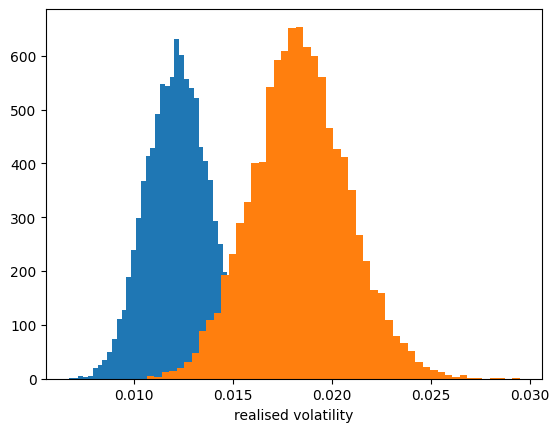

In [69]:
plt.hist(vol20_real_vol, bins=50)
plt.hist(vol30_real_vol, bins=50)
plt.xlabel('realised volatility')
plt.show()

The results of the simulations are presented below:

Note that the call has implied 20 vol, so we expect to make a profit if the price series is simulated at 30 vol and the risk-free rate = 0 if the price series is simulated at 20 vol.

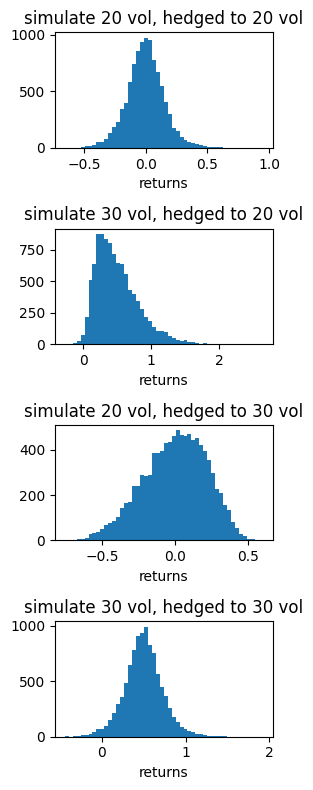

In [70]:
# Create a figure and subplots
fig, axs = plt.subplots(4, 1, figsize=(3, 8))

# Plotting the first subfigure
axs[0].hist(vol20_hedge20_returns, bins=50)
axs[0].set_title('simulate 20 vol, hedged to 20 vol')
axs[0].set_xlabel('returns')

# Plotting the second subfigure
axs[1].hist(vol30_hedge20_returns, bins=50)
axs[1].set_title('simulate 30 vol, hedged to 20 vol')
axs[1].set_xlabel('returns')

# Plotting the third subfigure
axs[2].hist(vol20_hedge30_returns, bins=50)
axs[2].set_title('simulate 20 vol, hedged to 30 vol')
axs[2].set_xlabel('returns')

# Plotting the fourth subfigure
axs[3].hist(vol30_hedge30_returns, bins=50)
axs[3].set_title('simulate 30 vol, hedged to 30 vol')
axs[3].set_xlabel('returns')



# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

We can plot a scatterplot of returns against final price.

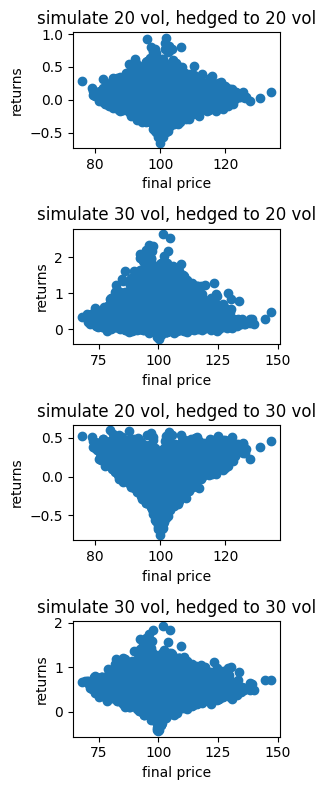

In [71]:
# Create a figure and subplots
fig, axs = plt.subplots(4, 1, figsize=(3, 8))

# Plotting the first subfigure
axs[0].scatter(vol20_final_price, vol20_hedge20_returns)
axs[0].set_title('simulate 20 vol, hedged to 20 vol')
axs[0].set_ylabel('returns')
axs[0].set_xlabel('final price')

# Plotting the second subfigure
axs[1].scatter(vol30_final_price, vol30_hedge20_returns)
axs[1].set_title('simulate 30 vol, hedged to 20 vol')
axs[1].set_ylabel('returns')
axs[1].set_xlabel('final price')

# Plotting the third subfigure
axs[2].scatter(vol20_final_price, vol20_hedge30_returns)
axs[2].set_title('simulate 20 vol, hedged to 30 vol')
axs[2].set_ylabel('returns')
axs[2].set_xlabel('final price')

# Plotting the fourth subfigure
axs[3].scatter(vol30_final_price, vol30_hedge30_returns)
axs[3].set_title('simulate 30 vol, hedged to 30 vol')
axs[3].set_ylabel('returns')
axs[3].set_xlabel('final price')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

### Returns against final stock price

If we hedge to the true value, the returns are symmetrical about the x-axis (or some profit level). This is because regardless of final stock price, the returns are random and due to the truncation error as previously discussed. We are equally like to end with a profit or loss with regards to the hedging.

The scatterplot tapers off to the sides and bunch up in the middle due to the nature of the path of the stock price. If the final stock price is very low, the stock price probably went low quickly. This means that the delta of the call went to 0 quickly. Therefore, the hedge position did not change much and the error profit due to hedging is small. Similarly, if the final stock price is very high, the delta of the call went to 1 quickly and did not change much. The error profit remains small. It did not matter if we did not rebalance the hedge in these cases.

Consider the case where we are hedging to 30 vol but the actual stock price is simulated to 20 vol. For a ITM option, this means that the delta of model is smaller than the delta of a correctly priced option. For example, if vol is high, there is a greater chance that an ITM option will end up OTM and since delta is roughly the chance that the option ends up ITM, the delta of an ITM option with a higher vol is lower. In other words, the sensitivity of delta to volatility of an ITM option is negative. Conversely by the same logic, the sensitivity of delta to volatility of an OTM option is positive. Therefore, if we have an ITM option and we hedge to 30 vol when the actual vol is 20, our model underestimates the delta of the option and we are under-hedged.

If the final stock price is extremely high or low, we can infer that the path of the stock price is somewhat straight. Consider the case when the stock price goes to an extremely high price (say from 100 to 200), in this case, the call option is almost always ITM. As previously mentioned, we are under-hedged in terms of delta, and this means that we are net long delta in a situation when the stock price is going up. Therefore, we make a profit.

Conversely, if the stock price goes down in a straight line, the option is always OTM. Therefore, our model overestimates the delta and we are over-hedged. Therefore, we are net short delta in a situation where the stock price goes down. Again, we make a profit.

When the final stock price is close to 100, the stock price series is roughly mean-reverting. Therefore, we tend to be under-hedged and long delta when prices are falling and over-hedged and short delta when prices are rising. 

This explains why we make a profit when the stock price is in the extremes, but lose money when the stock price remains around 100 if the actual stock price is simulated at 20 vol and we hedge to 30 vol.

The converse is true when we hedge to 20 vol and the stock price is simulated at 30 vol. We make losses when the final stock price is in the extremes since we are over-hedged when stock prices go up quickly and under-hedged when stock prices fall quickly.

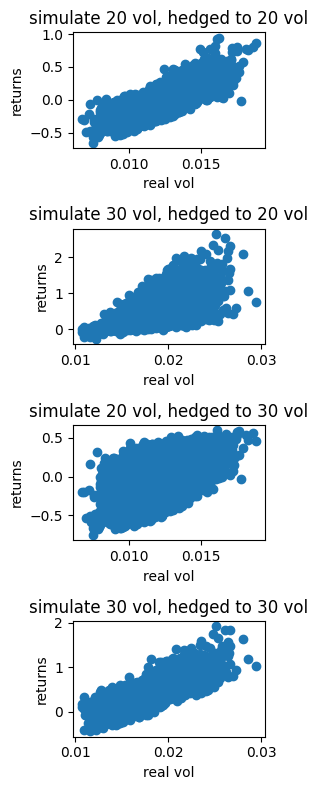

In [72]:
# Create a figure and subplots
fig, axs = plt.subplots(4, 1, figsize=(3, 8))

# Plotting the first subfigure
axs[0].scatter(vol20_real_vol, vol20_hedge20_returns)
axs[0].set_title('simulate 20 vol, hedged to 20 vol')
axs[0].set_ylabel('returns')
axs[0].set_xlabel('real vol')

# Plotting the second subfigure
axs[1].scatter(vol30_real_vol, vol30_hedge20_returns)
axs[1].set_title('simulate 30 vol, hedged to 20 vol')
axs[1].set_ylabel('returns')
axs[1].set_xlabel('real vol')

# Plotting the third subfigure
axs[2].scatter(vol20_real_vol, vol20_hedge30_returns)
axs[2].set_title('simulate 20 vol, hedged to 30 vol')
axs[2].set_ylabel('returns')
axs[2].set_xlabel('real vol')

# Plotting the fourth subfigure
axs[3].scatter(vol30_real_vol, vol30_hedge30_returns)
axs[3].set_title('simulate 30 vol, hedged to 30 vol')
axs[3].set_ylabel('returns')
axs[3].set_xlabel('real vol')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

### Returns against realised vol

We note that for all cases, the returns are higher when the realised volatility is higher.

By the black-scholes model, we claim that the P&L due to hedging should be 0 and any errors due to discrete hedging should be random. Moreover, realised volatility is random and cannot be predicted from the simulation volatility. Therefore, we may suspect that the returns should be random and not dependent on the realised volatility.

However, we must note that for each case, we bought a call at 20 implied vol and hedged it and we are specifically betting on higher volatility. Therefore, if the realised volatility is high, even if this is due to randomness, the profitability of our position increases.